In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

#### Load data and sort

In [2]:
df = pd.read_csv('Gold_standard_variable_candidates_all.csv')

In [3]:
df=df.iloc[0]
S_nu =np.array([1.5842688490e-4,df['I_JVLA2011_ep1'],df['I_JVLA2011_ep2'],df['I_JVLA2018']])*1000
S_nu_err=np.array([8.921042386348e-5,df['Ierr_JVLA2011_ep1'],df['Ierr_JVLA2011_ep2'],df['Ierr_JVLA2018']])*1000
days_1999=1+1000 #Assuming 1 day after explosion 
days_2011_e1=4488+1000
days_2011_e2=4490+1000
days_2018=6928+1000
t=np.array([days_1999,days_2011_e1,days_2011_e2,days_2018])
nu = 1.4



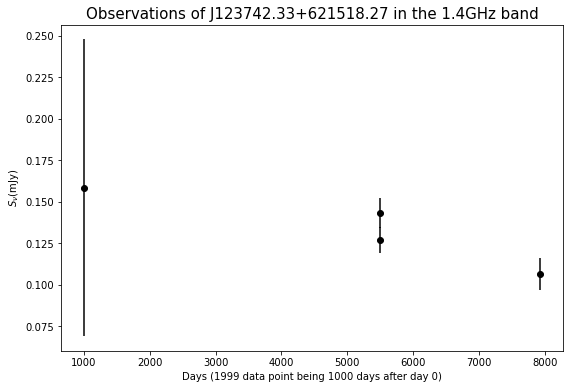

In [4]:
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black")
plt.title("Observations of J123742.33+621518.27 in the 1.4GHz band",fontsize=15)
plt.xlabel('Days (1999 data point being 1000 days after day 0)',fontsize=10)
plt.ylabel(r'$S_\nu$(mJy)',fontsize=10)
plt.show()

### Set up mcmc

Model
$$
\begin{aligned}
S(\nu, t)&=K_{1}\left(\frac{\nu}{5 \mathrm{GHz}}\right)^{\alpha}\left(\frac{t}{1 \mathrm{day}}\right)^{\beta} e^{-\tau_{\mathrm{ffa}}} \\
\tau_{\mathrm{ffa}}&=K_{2}\left(\frac{\nu}{5 \mathrm{GHz}}\right)^{-2.1}\left(\frac{t}{1 \mathrm{day}}\right)^{\delta}
\end{aligned}
$$
where $K_1, K_2, \alpha$ and $\beta$ are the parameters we will be fitting for. NB: $\delta = -3 + \alpha - \beta$

In [5]:
def model(theta,t=t,nu=nu):
    K1,K2,alpha,beta,t0 = theta
    tau=K2*(nu/5)**(-21/10)*(t-t0)**(-3+alpha-beta)
    S=K1*(nu/5)**(alpha)*(t-t0)**(beta)*np.exp(-tau)
    return S

In [6]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

In [7]:
def lnprior(theta):
    K1,K2,alpha,beta,t0 = theta
    if 0 < K1<1e2  and 0.0 < K2<1e9  and -3.0 < alpha < 0 and -3.0 < beta < 0 and 0.0 < t0<1000 :
        return 0.0
    return -np.inf

In [8]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [9]:
data = (t, S_nu,S_nu_err)
nwalkers = 2000
niter = 5000
initial = np.array([3.0e1, 4.0e8, -0.7, -0.7,450])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]




In [10]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 300)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [11]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [12]:
def plotter(sampler,t=t,S_nu=S_nu,nu=nu):
    plt.ion()
    plt.plot(t,S_nu,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(t, model(theta, t,nu), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('t')
    plt.ylabel(r'$S_\nu$')
    plt.legend()
    plt.show()

In [13]:
#fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#labels = ['K1','K2','alpha','beta','t0']
#for i in range(ndim):
    #ax = axes[i]
    #ax.plot(samples[:, :, i], "k", alpha=0.3)
    #ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

#axes[-1].set_xlabel("step number");

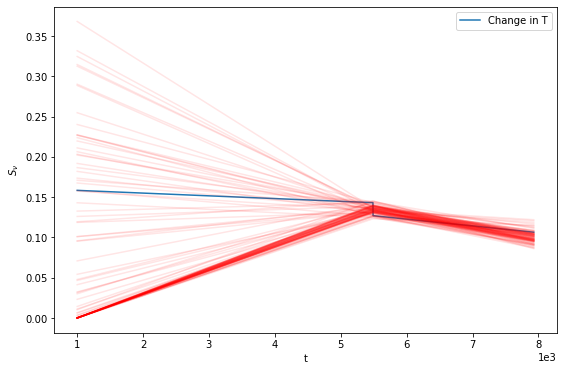

In [14]:
plotter(sampler)

In [15]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]


array([ 7.28950960e+00,  4.22360621e+08, -9.59624391e-01, -6.08187922e-01,
        1.52317616e+02])

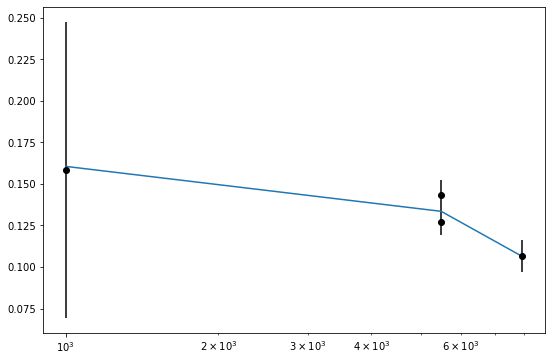

Theta max:  [ 7.28950960e+00  4.22360621e+08 -9.59624391e-01 -6.08187922e-01
  1.52317616e+02]


In [16]:
samples = sampler.flatchain
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black")
plt.plot(t,best_fit_model,label='Highest Likelihood Model')
plt.xscale('log')
plt.show()
print('Theta max: ',theta_max)

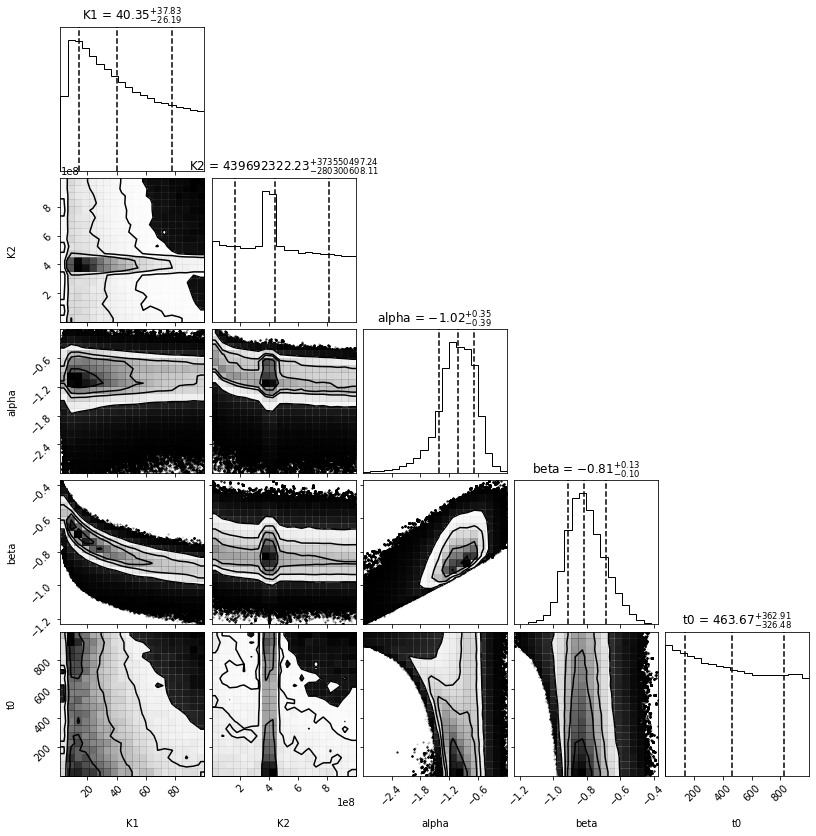

In [17]:
labels = ['K1','K2','alpha','beta','t0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [18]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

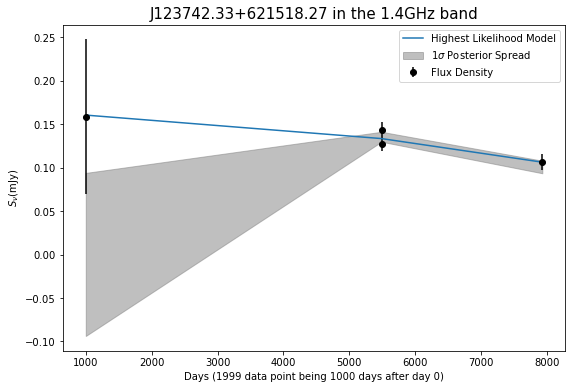

In [19]:
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black",label="Flux Density")
plt.plot(t,best_fit_model,label='Highest Likelihood Model')
plt.fill_between(t,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.title("J123742.33+621518.27 in the 1.4GHz band",fontsize=15)
plt.xlabel('Days (1999 data point being 1000 days after day 0)',fontsize=10)
plt.ylabel(r'$S_\nu$(mJy)',fontsize=10)
plt.legend()
plt.show()

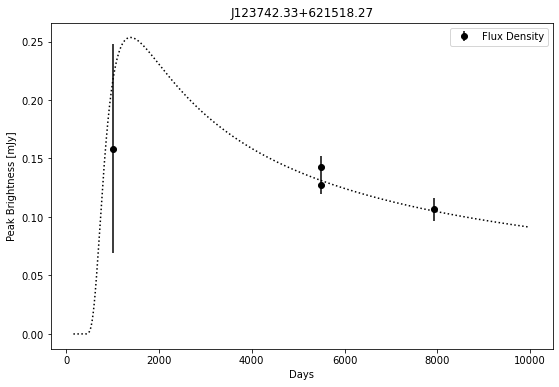

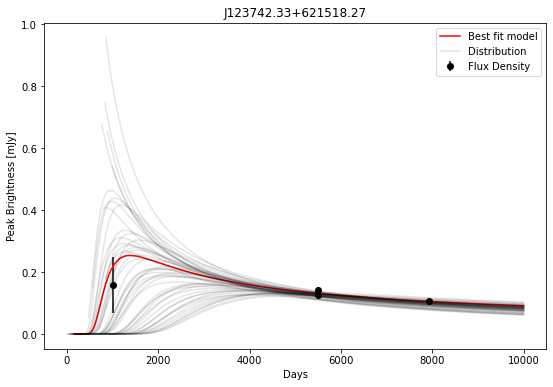

In [20]:
#Plot model
K1,K2,alpha,beta,t0=theta_max
day=np.arange(t0,10000)
tau=K2*(nu/5)**(-21/10)*(day)**(-3+alpha-beta)
S=K1*(nu/5)**(alpha)*(day)**(beta)*np.exp(-tau)
plt.plot(day,S,":k")
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black",label="Flux Density")
plt.title("J123742.33+621518.27")
plt.xlabel("Days")
plt.ylabel("Peak Brightness [mJy]")
plt.legend()
plt.show()

l=np.where(S==np.max(S))


K1,K2,alpha,beta,t0=theta_max
day=np.arange(t0,10000)
tau=K2*(nu/5)**(-21/10)*(day)**(-3+alpha-beta)
S=K1*(nu/5)**(alpha)*(day)**(beta)*np.exp(-tau)
plt.plot(day,S,"r",label="Best fit model")
plt.title("J123742.33+621518.27")
plt.xlabel("Days")
plt.ylabel("Peak Brightness [mJy]")


sam=samples[:50]
for i in sam:
    K1,K2,alpha,beta,t0=i
    day=np.arange(t0,10000)
    tau=K2*(nu/5)**(-21/10)*(day)**(-3+alpha-beta)
    S=K1*(nu/5)**(alpha)*(day)**(beta)*np.exp(-tau)
    plt.plot(day,S,"k",alpha=0.1)
    
plt.plot(day,S,"k",alpha=0.1,label="Distribution") 
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black",label="Flux Density")
plt.legend()
    
plt.show()
